In [5]:
import numpy as np
import pandas as pd
import scipy.sparse as ssparse
from ctypes import *
import scipy.io as sio
import matplotlib.pyplot as plt

sys.path.insert(0, '/home/bingyu')
from sp import interface

In [63]:
links_df0 = pd.read_csv('../osm/tokyo_edges.csv')
links_df0['fft'] = links_df0['length']/links_df0['maxmph']*2.237
links_df0['fft'] = np.where(links_df0['type'].isin(['motorway', 'motorway_link']), links_df0['fft']*0.1, links_df0['fft'])
nodes_df0 = pd.read_csv('../osm/tokyo_nodes.csv')

# wgh = links_df0['fft']
# row = links_df0['start_igraph']
# col = links_df0['end_igraph']
# g_coo = ssparse.coo_matrix((wgh, (row, col)), shape=(nodes_df0.shape[0], nodes_df0.shape[0]))
# sio.mmwrite('network_sparse_mex_analysis.mtx', g_coo)
# g = interface.readgraph(bytes('network_sparse_mex_analysis.mtx', encoding='utf-8'))


In [100]:
### add geometry
quarter_edge_vol = pd.read_csv('../simulation_outputs/edge_vol_distance/small_edge_vol_h{}_q{}.csv'.format(5, 0))
print(quarter_edge_vol.shape)
quarter_edge_vol = pd.merge(quarter_edge_vol, links_df0[['edge_id_igraph', 'length', 'geometry']], how='left', left_on='edgeid', right_on='edge_id_igraph')
print(np.sum(quarter_edge_vol['length']*quarter_edge_vol['vol'])/19876)
# quarter_edge_vol.to_csv('../simulation_outputs/edge_vol_geom/edge_vol_discount_geom_h{}_q{}.csv'.format(5, 0))

(449159, 2)
9625.961086562576


In [64]:
### match quarterly measures with osm locations
quarterly_measures = pd.read_csv('quarterly_measure.csv')
group_measures = quarterly_measures.groupby('obs_grp_id').agg({'start': 'first', 'end': 'first', 'dir': 'first'}).reset_index()
g = interface.readgraph(bytes('network_sparse_mex_analysis.mtx', encoding='utf-8'))
nodes_df = pd.read_csv('../osm/tokyo_nodes.csv')
group_measures = group_measures.merge(nodes_df[['node_osmid', 'node_id_igraph']], how='left', left_on='start', right_on='node_osmid')
group_measures = group_measures.merge(nodes_df[['node_osmid', 'node_id_igraph']], how='left', left_on='end', right_on='node_osmid', suffixes=['_start', '_end'])
print(group_measures.shape)
group_measures = group_measures.dropna(subset=['node_id_igraph_start', 'node_id_igraph_end'])
print(group_measures.shape)
group_measures['start_igraph'] = group_measures['node_id_igraph_start'].astype(int)
group_measures['end_igraph'] = group_measures['node_id_igraph_end'].astype(int)

obs_grp_edge_list = []
# group_measures2 = group_measures.loc[~group_measures['obs_grp_id'].isin(range(43,88))]
for row in group_measures.itertuples():
    obs_grp_id = getattr(row, 'obs_grp_id')
    dir = getattr(row, 'dir')
    if obs_grp_id in [110, 116]:
        continue
    elif obs_grp_id in range(43,88):
        if dir == 2:
            start_igraph = getattr(row, 'end_igraph')
            end_igraph = getattr(row, 'start_igraph')
        elif dir == 1:
            start_igraph = getattr(row, 'start_igraph')
            end_igraph = getattr(row, 'end_igraph')
        else:
            print('invalid direction')
            print(dir)
    else:
        if dir == 1:
            start_igraph = getattr(row, 'end_igraph')
            end_igraph = getattr(row, 'start_igraph')
        elif dir == 2:
            start_igraph = getattr(row, 'start_igraph')
            end_igraph = getattr(row, 'end_igraph')
        else:
            print('invalid direction')
            print(dir)
    # print(start_igraph, end_igraph)

    try:
        sp = g.dijkstra(start_igraph+1, end_igraph+1)
    except ArgumentError:
        print(end_igraph)
    sp_dist = sp.distance(end_igraph+1)
    if sp_dist > 10e7:
        print('route not found')
        sp.clear()
    else:
        sp_route = sp.route(end_igraph+1)
        route_igraph = [(start_sp-1, end_sp-1) for (start_sp, end_sp) in sp_route]
        if len(route_igraph)>20:
            pass
        else:
            obs_grp_edge_list += [(start, end, obs_grp_id) for (start, end) in route_igraph]
        sp.clear()

obs_grp_edge_df = pd.DataFrame(obs_grp_edge_list, columns=['start_igraph', 'end_igraph', 'obs_grp_id'])
print(obs_grp_edge_df.groupby('obs_grp_id').size())
obs_grp_edge_df = pd.merge(obs_grp_edge_df, links_df0[['start_igraph', 'end_igraph', 'edge_id_igraph', 'length']], how='left', on=['start_igraph', 'end_igraph'])
# obs_grp_edge_df.groupby(['start_igraph', 'end_igraph']).size().reset_index()
obs_grp_edge_df.head()

(281, 8)
(233, 8)
obs_grp_id
0      1
1      1
3      2
4      2
5      1
      ..
281    1
282    1
283    1
284    2
285    3
Length: 229, dtype: int64


,start_igraph,end_igraph,obs_grp_id,edge_id_igraph,length
0,92769,111409,0,136131,1243.587507
1,111409,552397,1,136132,1491.583447
2,552406,82528,3,1133750,562.926005
3,82528,526399,3,1133746,1537.544959
4,526399,616986,4,1133747,306.115010


In [72]:
### measurements
quarterly_measures = pd.read_csv('quarterly_measure.csv')
daily_measures = quarterly_measures.groupby('obs_grp_id').agg({'Q': np.sum}).reset_index()
daily_measures[daily_measures['obs_grp_id']==50].head()

,obs_grp_id,Q
50,50,28037.9


In [70]:
daily_sim_vol = obs_grp_edge_df.copy()
daily_sim_vol = daily_sim_vol.drop_duplicates(subset='edge_id_igraph')
daily_sim_vol['daily_vol'] = 0
for hour in range(5,6):
    for quarter in range(1):
        quarter_sim_vol = pd.read_csv('../simulation_outputs/edge_vol/edge_vol_h{}_q{}.csv'.format(hour, quarter))
        quarter_sim_vol = quarter_sim_vol.loc[quarter_sim_vol['edgeid'].isin(daily_sim_vol['edge_id_igraph'])]
        daily_sim_vol = pd.merge(daily_sim_vol, quarter_sim_vol, how='left', left_on='edge_id_igraph', right_on='edgeid')
        daily_sim_vol['daily_vol'] += daily_sim_vol.fillna(value={'vol': 0})['vol']
        daily_sim_vol = daily_sim_vol[['obs_grp_id', 'edge_id_igraph', 'length', 'daily_vol']]
        # break
    # break
daily_sim_vol.sort_values(by='daily_vol', ascending=False).head()

,obs_grp_id,edge_id_igraph,length,daily_vol
65,44,211,1325.302875,203.0
64,44,1164751,60.669454,203.0
66,44,150,60.102157,203.0
76,50,140599,63.356397,189.0
77,51,1657330,1693.555618,184.0


In [78]:
daily_edge_vol = daily_edge_vol.merge(links_df0[['edge_id_igraph', 'type']], how='left', on='edge_id_igraph')
daily_edge_vol.groupby('type').size()

type
motorway         363
motorway_link     26
primary            4
secondary          1
dtype: int64

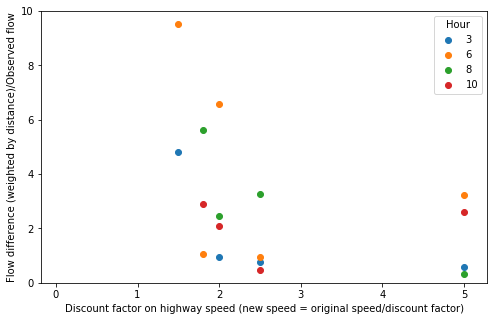

hour                3.00
quarter             0.00
hwy_discnt          0.10
Q_obs_mean         55.67
Q_obs_med          58.20
Q_sim_mean       7549.00
Q_sim_med        5280.00
Q_diff_mean      7493.33
Q_diff_med       5237.70
Q_diff_25        1315.00
Q_diff_75       12618.78
Q_wdiff_mean     5816.55
Q_wdiff_med      4213.62
Q_wdiff_25       1187.30
Q_wdiff_75       8659.50
Name: 0, dtype: float64

In [36]:
test = pd.read_csv('parameter_sensitivity.csv')

fig, ax = plt.subplots(figsize=(8,5))
# color_dict=[3:'r', 6:'b']
for nm, grp in test.groupby('hour'):
    ax.scatter(grp['hwy_discnt'], grp['Q_wdiff_mean']/grp['Q_obs_mean'], label=nm)
plt.xlabel('Discount factor on highway speed (new speed = original speed/discount factor)')
plt.ylabel('Flow difference (weighted by distance)/Observed flow')
# plt.yscale('log')
# plt.xlim([1.6, 2.1])
plt.ylim([0, 10])
plt.legend(title='Hour')
plt.show()
test.iloc[0]